In [1]:
install.packages("glmnet")
install.packages("caret")
install.packages("dplyr")
install.packages("pROC")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpWL3PNT/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpWL3PNT/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpWL3PNT/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpWL3PNT/downloaded_packages


In [3]:
library(glmnet)
library(caret)
library(dplyr)
library(pROC)

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var




# Import and format data

In [22]:
#read in the data
data <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/fieldwork_regression_table.csv")
#check col names and structure
#names(data)
#str(data)
#new df without  cols not used
trim_data <- data %>% select(-identifier, -score_min, -score_ellen, -score_aadya, -serviceable_ellen, -serviceable_aadya)
#remove problematic cols
trim_data <- trim_data %>% select(-IT01V_frameHeight_ellen, -IT01V_frameHeight_aadya)
#remove all aadya cols
trim_data <- trim_data %>% select(-contains("aadya"))
#remove all outbound cols
#trim_data <- trim_data %>% select(-contains("OT01V"))
#trim_data <- trim_data %>% select(-contains("OT01A"))


Divide into train and test

In [23]:
set.seed(6)  # for reproducibility
train_index <- createDataPartition(trim_data$serviceable_agg, p = 0.7, list = FALSE)
train_data <- trim_data[train_index, ]
test_data <- trim_data[-train_index, ]

format as matrices for fitting

In [24]:
x_train <- as.matrix(train_data[, -which(names(train_data) == "serviceable_agg")])
y_train <- train_data$serviceable_agg

x_test <- as.matrix(test_data[, -which(names(test_data) == "serviceable_agg")])
y_test <- test_data$serviceable_agg


# Approach 1: Setting alpha manually

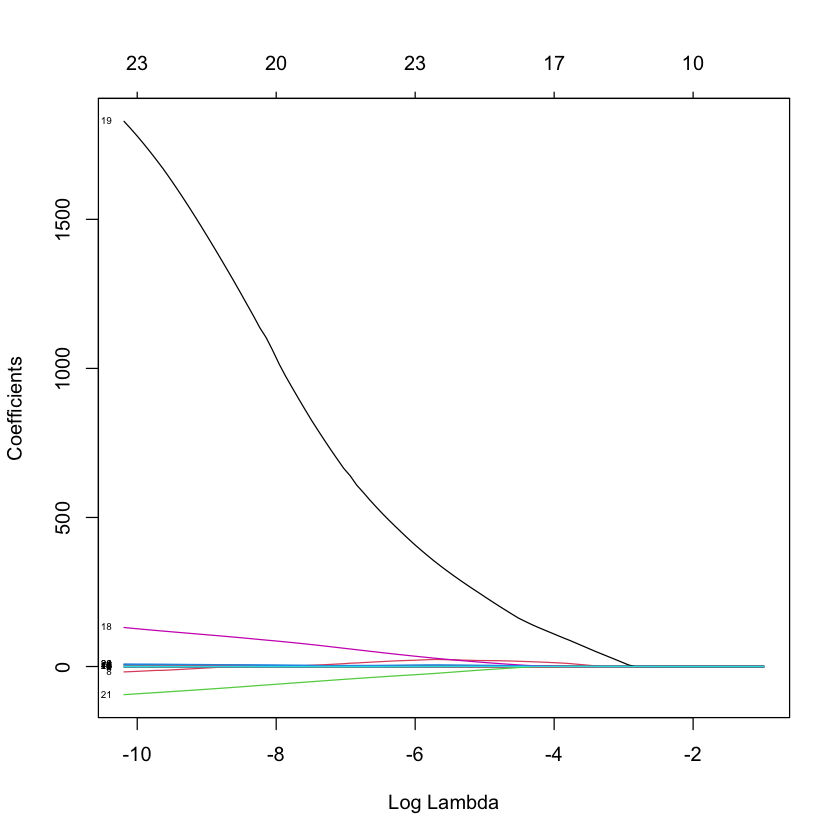

24 x 1 sparse Matrix of class "dgCMatrix"
                                                              s0
(Intercept)                                        -3.107314e+00
IT01V_packetsRecieved_ellen                         4.338456e-04
IT01V_packetsLost_ellen                             .           
IT01V_frameWidth_ellen                              9.598599e-04
IT01V_totalFreezesDuration_ellen                    .           
IT01V_framesPerSecond_ellen                         1.964650e-02
IT01V_bytesReceived_in_bits_s_ellen                 .           
IT01V_totalProcessingDelay_ellen                   -4.181091e-03
IT01V_jitter_ellen                                  .           
IT01V_jitterBufferDelay_emissions_ellen            -7.010504e-05
IT01A_bytesReceived_in_bits_s_ellen                 .           
IT01A_jitterBufferDelay_emissions_ellen            -6.931066e-05
OT01V_packetsSent_s_ellen                           1.330908e-03
OT01V_bytesSent_in_bits_s_ellen                 

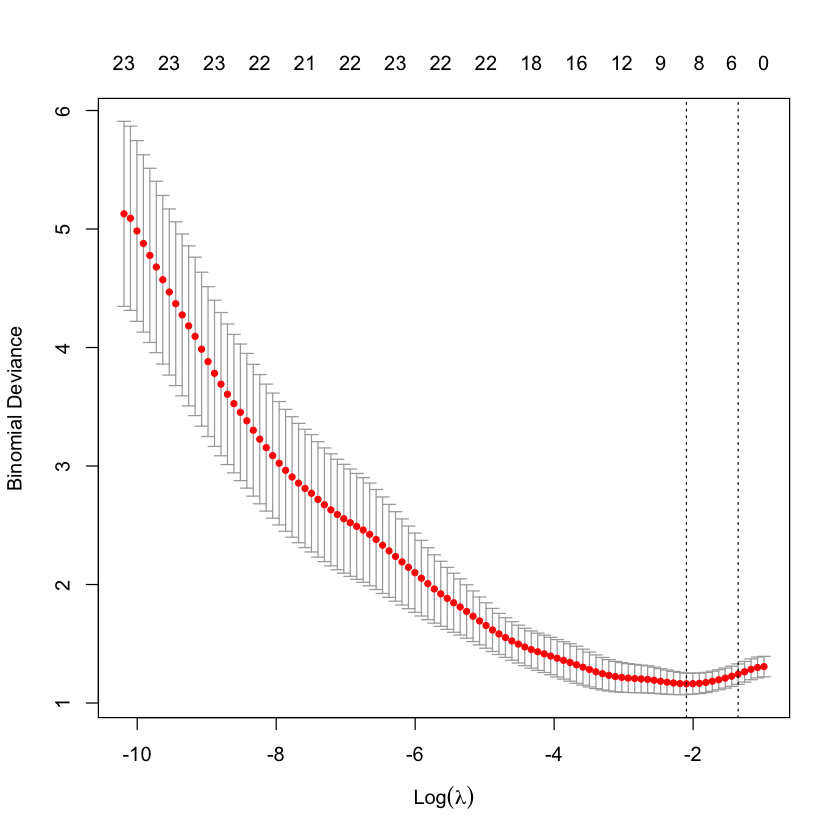

In [25]:
# alpha = 0.5(elastic net)
par(bg= "white")
model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the coefficient paths
plot(model_manual, xvar = "lambda", label = TRUE)

# Perform cross-validation to find the optimal lambda
cv_model_manual <- cv.glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the cross-validation curve
plot(cv_model_manual)

# Get the best lambda
best_lambda <- cv_model_manual$lambda.min

# Fit the final model with the best lambda
final_model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5, lambda = best_lambda)

# Print the coefficients
coef(final_model_manual)

### Summary of output

In [26]:



#isolate only the vars it selected
selected_vars <- rownames(coef(final_model_manual))[-1][coef(final_model_manual)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("serviceable_agg ~", paste(selected_vars, collapse = " + ")))

# Fit a standard logistic regression model
logistic_model <- glm(formula, data = train_data, family = "binomial")
summary(logistic_model)



Call:
glm(formula = formula, family = "binomial", data = train_data)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -9.965e+00  5.050e+00  -1.973   0.0485
IT01V_packetsRecieved_ellen             -3.510e-02  2.829e-02  -1.241   0.2147
IT01V_frameWidth_ellen                   9.348e-03  5.183e-03   1.804   0.0713
IT01V_framesPerSecond_ellen             -1.903e-03  1.131e-01  -0.017   0.9866
IT01V_totalProcessingDelay_ellen        -1.175e-02  3.182e-02  -0.369   0.7121
IT01V_jitterBufferDelay_emissions_ellen -4.778e-03  1.116e-02  -0.428   0.6687
IT01A_jitterBufferDelay_emissions_ellen -3.468e-03  3.288e-03  -1.055   0.2915
OT01V_packetsSent_s_ellen                2.587e-01  2.160e-01   1.198   0.2311
OT01V_bytesSent_in_bits_s_ellen         -2.857e-05  2.335e-05  -1.223   0.2211
OT01V_framesPerSecond_ellen              8.399e-02  8.655e-02   0.970   0.3318
                                         
(Int

# Approach 2: Using cross-validation to find the optimal alpha

Function to perform cross validation

In [27]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, family = "binomial", alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)
}

Warning message:
"from glmnet C++ code (error code -84); Convergence for 84th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned"


Best alpha: 0.7 


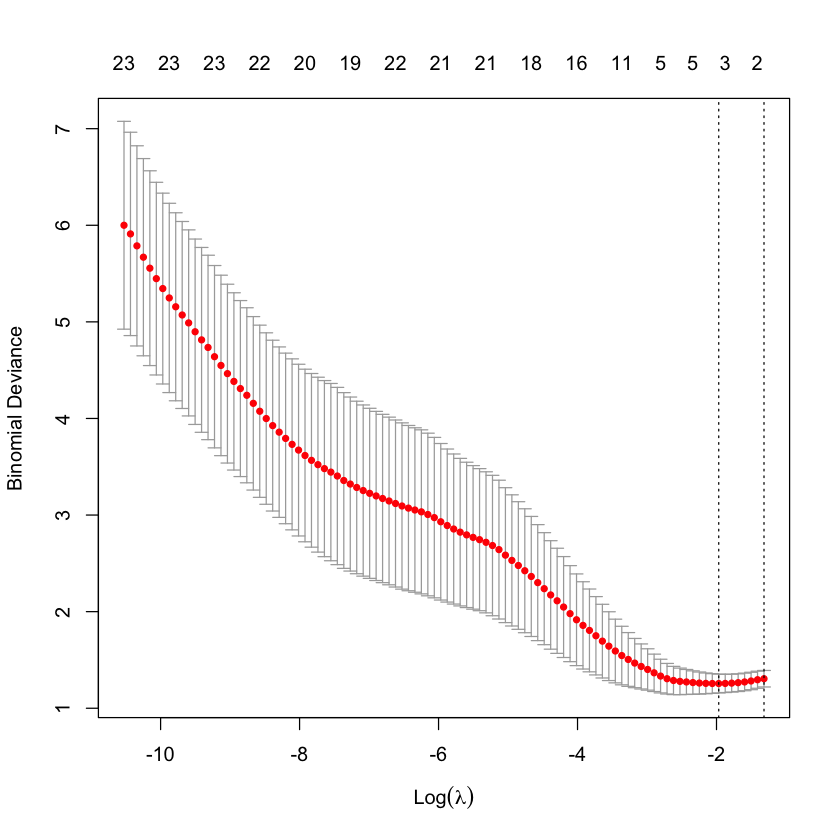

In [28]:
# Find the best alpha
best_alpha <- cv_alpha(x_train, y_train)
cat("Best alpha:", best_alpha, "\n")

# Fit the model with the best alpha
cv_model_best <- cv.glmnet(x_train, y_train, family = "binomial", alpha = best_alpha)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x_train, y_train, family = "binomial", alpha = best_alpha, lambda = best_lambda)


In [29]:
#isolate only the vars it selected
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("serviceable_agg ~", paste(selected_vars, collapse = " + ")))

# Fit a standard logistic regression model
logistic_model <- glm(formula, data = train_data, family = "binomial")
# Get the summary of the model, which includes p-values
summary_output <- summary(logistic_model)

# Extract coefficients and p-values
coef_summary <- data.frame(
  Estimate = summary_output$coefficients[, "Estimate"],
  `Std. Error` = summary_output$coefficients[, "Std. Error"],
  `z value` = summary_output$coefficients[, "z value"],
  `Pr(>|z|)` = summary_output$coefficients[, "Pr(>|z|)"]
)

# Display the results
print(coef_summary)

                                     Estimate Std..Error    z.value   Pr...z..
(Intercept)                      -7.261809312 3.90165578 -1.8612122 0.06271422
IT01V_frameWidth_ellen            0.005239980 0.00367169  1.4271306 0.15354226
IT01V_framesPerSecond_ellen      -0.028024275 0.08605214 -0.3256662 0.74467691
IT01V_totalProcessingDelay_ellen -0.025919403 0.01610312 -1.6095885 0.10748773
OT01V_packetsSent_s_ellen        -0.002457299 0.01159671 -0.2118962 0.83218800
OT01V_framesPerSecond_ellen       0.121210298 0.07001623  1.7311744 0.08342067


predictions

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.6294118 


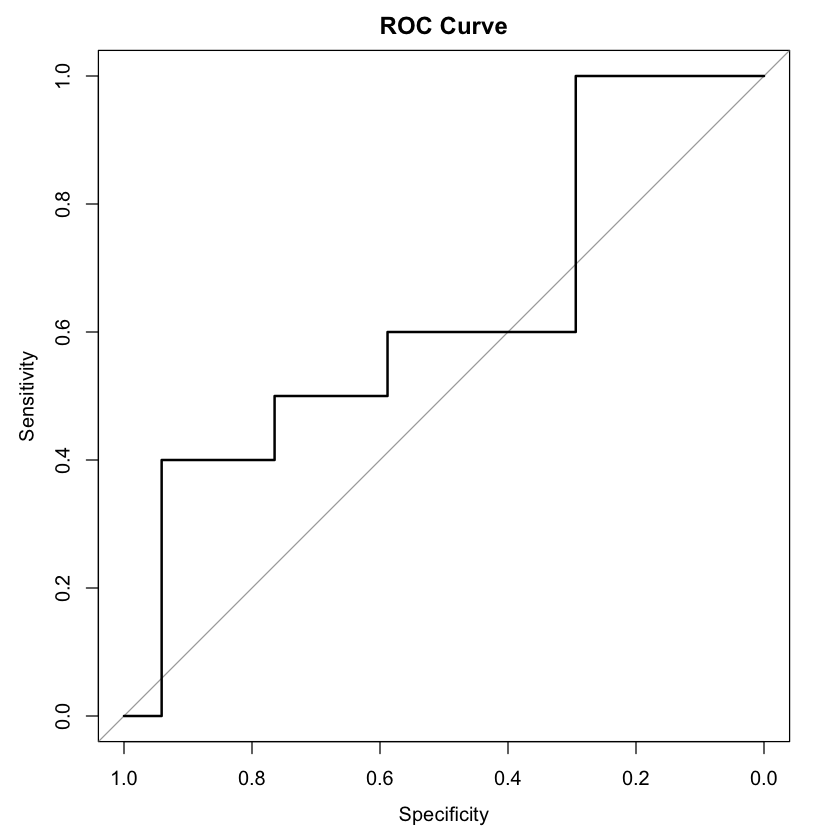

In [30]:
par(bg= "white")
# Make predictions on the test set
predictions <- predict(final_model_best, newx = x_test, type = "response", data = trim_data)
predictions_vector <- predictions[, 1]
# Evaluate the model
library(pROC)
roc_curve <- roc(y_test, predictions_vector)
auc_value <- auc(roc_curve)
cat("AUC:", auc_value, "\n")

# Plot ROC curve
plot(roc_curve, main = "ROC Curve")